In [38]:
from lightfm import LightFM
from lightfm.datasets import fetch_movielens
from lightfm.evaluation import precision_at_k

import numpy as np
import pandas as pd

import os
import json

import tqdm

%matplotlib inline

DATA_PATH = './data/'
PREDICT_PATH = './predictions/'

In [2]:
with open(os.path.join(DATA_PATH, 'test_users.json'), 'r') as f:
    test_users = set(json.load(f)['users'])

In [3]:
%%time
df_catalogue = pd.read_json(
    os.path.join(DATA_PATH, 'catalogue.json'), orient = 'index', typ = 'frame'
    )
df_catalogue.index.rename('element_uid', inplace = True)
df_catalogue.drop(['attributes', 'availability'], axis = 1, inplace = True)
print(df_catalogue.shape)

(10200, 7)
CPU times: user 1.64 s, sys: 20.3 ms, total: 1.66 s
Wall time: 1.69 s


In [4]:
%%time
transactions = pd.read_csv(
    os.path.join(DATA_PATH, 'transactions.csv'),
    dtype={
        'element_uid': np.uint16,
        'user_uid': np.uint32,
        'consumption_mode': 'category',
        'ts': np.float64,
        'watched_time': np.uint64,
        'device_type': np.uint8,
        'device_manufacturer': np.uint8
    }
)
print (transactions.shape)

(9643012, 7)
CPU times: user 7.16 s, sys: 489 ms, total: 7.65 s
Wall time: 8.61 s


In [5]:
ratings = pd.read_csv(
    os.path.join(DATA_PATH, 'ratings.csv'),
    dtype={
        'element_uid': np.uint16,
        'user_uid': np.uint32,
        'ts': np.float64,
        'rating': np.float64
    }
)
print (ratings.shape)

(438790, 4)


In [6]:
bookmarks = pd.read_csv(
    os.path.join(DATA_PATH, 'bookmarks.csv'),
    dtype={
        'element_uid': np.uint16,
        'user_uid': np.uint32,
        'ts': np.float64
    }
)
bookmarks.rename({'ts': 'ts_bookmark'}, axis=1, inplace = True)
print(bookmarks.shape)
bookmarks.head()

(948216, 3)


,user_uid,element_uid,ts_bookmark
0,301135,7185,4.430516e+07
1,301135,4083,4.430516e+07
2,301135,10158,4.430516e+07
3,301135,2693,4.430516e+07
4,301135,2181,4.430515e+07


In [7]:
transactions = transactions.merge(df_catalogue, 
                                  how = 'left', 
                                  left_on = 'element_uid', right_index = True
                                 )

In [8]:
transactions['watched_ratio'] = (transactions.watched_time)/((transactions.duration + 5)*60)
transactions.head()

,element_uid,user_uid,consumption_mode,ts,watched_time,device_type,device_manufacturer,duration,feature_1,feature_2,feature_3,feature_4,feature_5,type,watched_ratio
0,3336,5177,S,4.430518e+07,4282,0,50,90,4.166108e+07,0.739609,45,1.141929,0.654707,movie,0.751228
1,481,593316,S,4.430518e+07,2989,0,11,50,4.293419e+07,0.750161,11,1.119409,0.592716,movie,0.905758
2,4128,262355,S,4.430518e+07,833,0,50,100,2.777730e+07,0.750161,12,1.130076,0.654707,movie,0.132222
3,6272,74296,S,4.430518e+07,2530,0,99,100,4.041556e+07,0.675218,34,1.140273,0.680410,movie,0.401587
4,5543,340623,P,4.430518e+07,6282,0,50,70,9.212964e+06,0.783234,14,1.113885,0.000000,movie,1.396000


In [ ]:
# Watched more than half of the film, if it is available for free or by subscription.
# Watched more than a third of the series, if it is available for free or by subscription

In [9]:
trans_positive = transactions[((transactions.watched_ratio >= 0.5) & (transactions.type == 'movie'))
                            | ((transactions.watched_ratio >= 0.33) & (transactions.type != 'movie'))]
trans_positive.reset_index(drop = True, inplace = True)
print(trans_positive.shape)
trans_positive.head()

(6356638, 15)


,element_uid,user_uid,consumption_mode,ts,watched_time,device_type,device_manufacturer,duration,feature_1,feature_2,feature_3,feature_4,feature_5,type,watched_ratio
0,3336,5177,S,4.430518e+07,4282,0,50,90,4.166108e+07,0.739609,45,1.141929,0.654707,movie,0.751228
1,481,593316,S,4.430518e+07,2989,0,11,50,4.293419e+07,0.750161,11,1.119409,0.592716,movie,0.905758
2,5543,340623,P,4.430518e+07,6282,0,50,70,9.212964e+06,0.783234,14,1.113885,0.000000,movie,1.396000
3,4208,356688,S,4.430518e+07,7229,0,11,110,6.204660e+06,0.789495,27,1.124804,0.654707,movie,1.047681
4,5651,490059,S,4.430518e+07,9390,0,50,20,4.193306e+07,0.677350,0,1.138604,0.654707,series,6.260000


In [ ]:
ratings = ratings.merge(trans_positive[['element_uid', 'user_uid', 'watched_ratio']], 
                        how = 'left', 
                        left_on = ['element_uid', 'user_uid'],
                        right_on =  ['element_uid', 'user_uid']
                       )
print (ratings.shape)

In [ ]:
ratings_extra = ratings[ratings.watched_ratio.isnull()]
print (ratings_extra.shape)

In [29]:
ratings_extra.rating.mean()

8.273304093567251

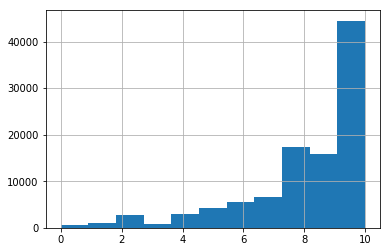

In [25]:
ratings_extra.rating.hist(bins = 11)

In [30]:
ratings_positive = ratings_extra[ratings_extra.rating >= 8]
print(ratings_positive.shape)

(77770, 5)


In [35]:
ratings_positive.head()

,user_uid,element_uid,rating,ts,watched_ratio
0,571252,1364,10.0,4.430517e+07,NaN
2,443817,4363,8.0,4.430514e+07,NaN
3,359870,1364,10.0,4.430506e+07,NaN
5,557663,1918,10.0,4.430505e+07,NaN
7,95790,5368,9.0,4.430500e+07,NaN


In [10]:
bookmarks = bookmarks.merge(trans_positive[['element_uid', 'user_uid', 'watched_ratio']], 
                        how = 'left', 
                        left_on = ['element_uid', 'user_uid'],
                        right_on =  ['element_uid', 'user_uid']
                       )
print (bookmarks.shape)

(948216, 4)


In [11]:
bookmarks_extra = bookmarks[bookmarks.watched_ratio.isnull()]
print (bookmarks_extra.shape)

(744714, 4)


In [12]:
interact_positive = pd.concat((trans_positive[['element_uid', 'user_uid']], 
                            bookmarks_extra[['element_uid', 'user_uid']]))
interact_positive.reset_index(inplace = True, drop = True)
print(interact_positive.shape)

(7101352, 2)


In [13]:
%%time
from lightfm.data import Dataset

dataset = Dataset()
dataset.fit((x for x in interact_positive.user_uid),
            (x for x in interact_positive.element_uid))

user_mapping = dataset.mapping()[0]
item_mapping = dataset.mapping()[2]

CPU times: user 13.2 s, sys: 130 ms, total: 13.3 s
Wall time: 13.7 s


In [14]:
num_users, num_items = dataset.interactions_shape()
print('Num users: {}, num_items {}.'.format(num_users, num_items))

Num users: 487539, num_items 9540.


In [ ]:
# для транзакций и каталога
dataset.fit_partial(items=(x['ISBN'] for x in get_book_features()),
                    item_features=(x['Book-Author'] for x in get_book_features()))

In [15]:
%%time
(interactions, weights) = dataset.build_interactions(((interact_positive.user_uid[i], 
                                                       interact_positive.element_uid[i]) 
                                                      for i in range(interact_positive.shape[0])))

print(repr(interactions))

<487539x9540 sparse matrix of type '<class 'numpy.int32'>'
	with 7101352 stored elements in COOrdinate format>
CPU times: user 13min 30s, sys: 248 ms, total: 13min 31s
Wall time: 13min 31s


In [69]:
from lightfm.cross_validation import random_train_test_split

(train, test) = random_train_test_split(interactions, test_percentage=0.2)

In [70]:
%%time
for n in [10, 20, 30]:
    for e in [10, 20]:
        model = LightFM(loss='warp', no_components=n)
        model.fit(train, epochs=e, num_threads=3)
        print("no_components: %s , epochs: %s" % (n, e))
        print("Test precision: %.5f" % precision_at_k(model, test, k=20, num_threads=3).mean())

no_components: 10 , epochs: 10
Test precision: 0.02838
no_components: 10 , epochs: 20
Test precision: 0.02911
no_components: 20 , epochs: 10
Test precision: 0.02972
no_components: 20 , epochs: 20
Test precision: 0.02981
no_components: 30 , epochs: 10
Test precision: 0.02963
no_components: 30 , epochs: 20
Test precision: 0.02937
CPU times: user 59min 23s, sys: 3.24 s, total: 59min 27s
Wall time: 23min 50s


In [ ]:
# только транзакции, обрезка по watched_ratio
5 10 0.026467944
10 10 0.027500955
20 10 0.028956437
20 20 0.028891606
30 10 0.028885659

In [ ]:
# транзакции, обрезка по watched_ratio + рейтинги 8 и выше
no_components: 10 , epochs: 10
Test precision: 0.028018
no_components: 10 , epochs: 20
Test precision: 0.028245
no_components: 20 , epochs: 10
Test precision: 0.028928
no_components: 20 , epochs: 20
Test precision: 0.028905
no_components: 30 , epochs: 10
Test precision: 0.029077
no_components: 30 , epochs: 20

In [ ]:
# транзакции, обрезка по watched_ratio + букмарки
no_components: 10 , epochs: 10
Test precision: 0.02838
no_components: 10 , epochs: 20
Test precision: 0.02911
no_components: 20 , epochs: 10
Test precision: 0.02972
no_components: 20 , epochs: 20
Test precision: 0.02981
no_components: 30 , epochs: 10
Test precision: 0.02963
no_components: 30 , epochs: 20
Test precision: 0.02937
CPU times: user 59min 23s, sys: 3.24 s, total: 59min 27s
Wall time: 23min 50s

In [16]:
%%time
model = LightFM(loss='warp', no_components=20)
model.fit(interactions, epochs=20, num_threads=3)

CPU times: user 5min 51s, sys: 451 ms, total: 5min 51s
Wall time: 2min 19s


In [17]:
interact_positive_users = set(interact_positive.user_uid.unique())
test_users_in_interact_positive = list(test_users & interact_positive_users)

In [18]:
movie_list = list(interact_positive.element_uid.unique())
int_item_ids = [item_mapping[x] for x in movie_list]
len(int_item_ids)

9540

In [19]:
top500 = {}

for user_uid in tqdm.tqdm(test_users_in_interact_positive):
    int_user_id = user_mapping[user_uid]
    scores = model.predict(int_user_id, int_item_ids, num_threads=3)
    top_items = np.array(movie_list)[np.argsort(-scores)]

    top500[user_uid] = top_items[:500]

100%|██████████| 49555/49555 [03:50<00:00, 215.11it/s]


In [29]:
from collections import defaultdict

filtered_elements = defaultdict(set)

for user_uid, element_uid in tqdm.tqdm(transactions.loc[:, ['user_uid', 'element_uid']].values):
    if user_uid not in test_users:
        continue
    filtered_elements[user_uid].add(element_uid)

100%|██████████| 9643012/9643012 [00:31<00:00, 304105.12it/s]


In [30]:
result = {}
for user_uid in tqdm.tqdm(test_users_in_interact_positive):
    result[user_uid] = [int(x) for x in top500[user_uid] if x not in filtered_elements[user_uid]][:20]

100%|██████████| 49555/49555 [02:02<00:00, 405.42it/s]


In [31]:
with open(os.path.join(PREDICT_PATH, 'lightfm_transactions_cut_bookmarks_filtered.json'), 'w') as f:
    json.dump(result, f)

In [179]:
# если добавить обший топ-20 для оставшихся ~600 пользователей
(50000-49417)/50000*0.0188 + 0.0281292

0.028348408

In [33]:
top20_ratings = ratings.groupby('element_uid').size().sort_values(ascending = False)[:20].index

In [34]:
interact_users = set(interact_positive.user_uid.unique())
len(test_users - interact_users)

445

In [35]:
for user_uid in tqdm.tqdm(test_users - interact_users):
    result[user_uid] = list(top20_ratings)

100%|██████████| 445/445 [00:00<00:00, 11751.93it/s]


In [37]:
with open(os.path.join(PREDICT_PATH, 'lightfm_transactions_cut_bookmarks_filtered_top20.json'), 'w') as f:
    json.dump(result, f)